# Import

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

# NLP preprocessing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split


In [31]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/leo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/leo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/leo/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/leo/nltk_data...


True

In [2]:
style.use("ggplot")

# Import data and exploration

## Data

In [30]:
df = pd.read_csv("data/Reviews.csv",index_col="Id")
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [31]:
df["Score"].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

In [32]:
display(df.isnull().sum())
print("As we will not use ProfileName & Summary, we don't have to handle those missing value")

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

As we will not use ProfileName & Summary, we don't have to handle those missing value


In [33]:
data = df[["Text","Score"]]


In [34]:
print(f'There can be 5 discrete value for the note attributed to an item : {sorted(data.Score.unique())}')

There can be 5 discrete value for the note attributed to an item : [1, 2, 3, 4, 5]


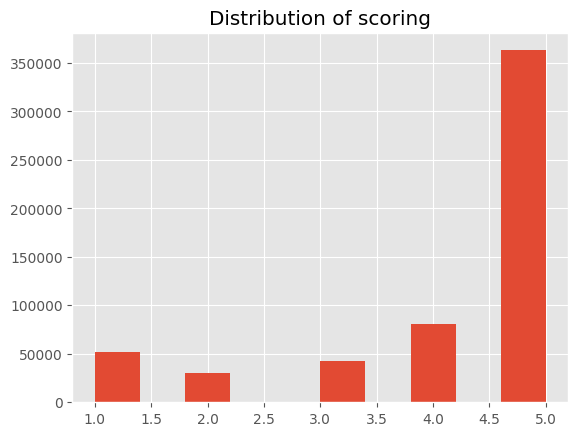

In [35]:
plt.hist(data["Score"])
plt.title("Distribution of scoring");

In [36]:
display(round(data["Score"].value_counts(normalize=True)*100,2))
print("As we can see, dataset is not balanced, with 63% being 5 star, and 37% split between the 4 other value")

5    63.88
4    14.19
1     9.19
3     7.50
2     5.24
Name: Score, dtype: float64

As we can see, dataset is not balanced, with 63% being 5 star, and 37% split between the 4 other value


In [37]:
data["Score"].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [38]:
five_star = data[data.Score == 5]
other_star = data[data.Score != 5]

In [39]:
less_5_star = five_star.sample(len(five_star)-300_000)

In [40]:
less_5_star

,Text,Score
Id,,
50663,I was excited to purchase BPA free canned bean...,5
409354,I put these in jars and put a ribbon around th...,5
194082,For all of my life Cashews were a delacy that ...,5
297570,Having multuple dogs to feed snacks to I can t...,5
110066,"If you are a Starbucks fan, and like their bol...",5
...,...,...
4197,Bisquick has made a wonderful gluten free prod...,5
551154,I have filled all my salt shakers with Redmond...,5
28891,I got the product in time and it is exactly wh...,5


In [41]:
new_df = pd.concat([less_5_star,other_star])

## Changing to Score to a good or bad review

In [42]:
def score(value):
    if value == 5 or value == 4:
        return 1
    elif value != 5:
        return 0

In [43]:
new_df["Score"] = new_df["Score"].apply(score)

In [44]:
new_df

,Text,Score
Id,,
50663,I was excited to purchase BPA free canned bean...,1
409354,I put these in jars and put a ribbon around th...,1
194082,For all of my life Cashews were a delacy that ...,1
297570,Having multuple dogs to feed snacks to I can t...,1
110066,"If you are a Starbucks fan, and like their bol...",1
...,...,...
568435,This soup is mostly broth. Although it has a k...,0
568436,"It is mostly broth, with the advertised 3/4 cu...",0
568440,We need this for a recipe my wife is intereste...,1


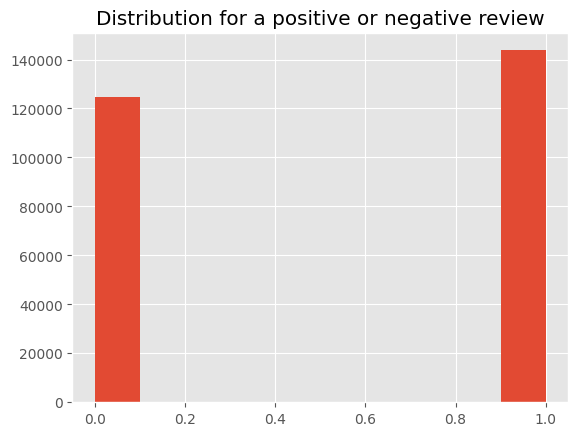

In [45]:
plt.hist(new_df["Score"])
plt.title("Distribution for a positive or negative review");

# Preprocessing

In [46]:
X = new_df.Text
y = new_df.Score

In [48]:
for _ in range(5):
   print(X.iloc[np.random.randint(0,len(X))])

If you're like me and LOVE Starbucks Green Tea Latte and Frappuccino, then try this Rishi Tea Sweet Matcha. Neither Tazo or Starbucks actually sells the green tea matcha powder they use to make their Green Tea Latte or Frappuccino. Why would they, if you knew you could make your own at home for considerably less. It has taken me several years now to finally find it, but this is it!!!! It comes with 3 small packs, but well worth it when you can make them in the convenience of your own home. Whether I am in the mood for a hot latte or a cold frappuccino, it is as easy as measuring the matcha green tea powder and adding it to your milk. For lattes, I simply mix it in a plastic bottle with a tight-fitting lid and shake it until it becomes nice and frothy. Then I nuke it for a minute or two and enjoy! For a frappuccino, I simply blend the milk, powder and some ice in a blender.
If you've never had marzipan, you might perhaps like the hint of almond flavor in this item. But if you know what 

In [117]:
def preprocessing(sentence):
    sentence = sentence.strip().lower()
    sentence = re.sub("/d+","",sentence)
    sentence = "".join([word for word in sentence if word not in string.punctuation])
    sentence = word_tokenize(sentence)
    sentence = [word for word in sentence if word not in stopwords.words("english")]
    sentence = " ".join([WordNetLemmatizer().lemmatize(word, pos="v") for word in sentence])
    return sentence

In [33]:
X = X.apply(preprocessing)

(0.0, 1000.0)

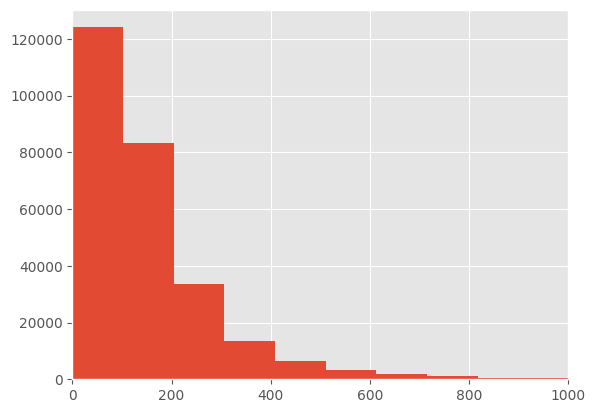

In [42]:
sentence_len = X.apply(lambda x: len(x))
plt.hist(sentence_len,bins=55)
plt.xlim(0,1000)

In [47]:
tk = Tokenizer()
tk.fit_on_texts(X)
X_token = tk.texts_to_sequences(X)

X_pad = pad_sequences(X_token,maxlen=300, dtype='float32', padding='post')

In [50]:
X_pad.shape

(268454, 300)

In [58]:
vocab_size = len(tk.word_index)

# Model

In [67]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size + 1,
                     output_dim = 100,
                     mask_zero = True))
model.add(layers.LSTM(20,activation="tanh",return_sequences=True))
model.add(layers.LSTM(20,activation="tanh"))
model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [68]:
model.fit(X_pad,y,epochs=10,batch_size=32)

Epoch 1/10


2023-03-23 20:34:43.315092: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-03-23 20:34:43.649814: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-03-23 20:34:45.270197: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8390/8390 [==============================] - 373s 43ms/step - loss: 0.6021 - accuracy: 0.6714
Epoch 2/10
8390/8390 [==============================] - 365s 43ms/step - loss: 0.5664 - accuracy: 0.7054
Epoch 3/10
8390/8390 [==============================] - 356s 42ms/step - loss: 0.5451 - accuracy: 0.7222
Epoch 4/10
8390/8390 [==============================] - 365s 43ms/step - loss: 0.5314 - accuracy: 0.7334
Epoch 5/10
8390/8390 [==============================] - 356s 42ms/step - loss: 0.5217 - accuracy: 0.7406
Epoch 6/10
8390/8390 [==============================] - 357s 43ms/step - loss: 0.5132 - accuracy: 0.7469
Epoch 7/10
8390/8390 [==============================] - 352s 42ms/step - loss: 0.5060 - accuracy: 0.7524
Epoch 8/10
8390/8390 [==============================] - 350s 42ms/step - loss: 0.4996 - accuracy: 0.7574
Epoch 9/10
8390/8390 [==============================] - 349s 42ms/step - loss: 0.4939 - accuracy: 0.7616
Epoch 10/10
8390/8390 [==============================] - 368s 44ms

# Reducing obsveration for each value to 25000 to have a balanced dataset

In [20]:
df_1 = data[data.Score == 1]
df_1 = df_1.sample(25000)
for i in range(2,6):
    df = data[data.Score == i]
    df = df.sample(25000)
    df_1 = pd.concat([df_1,df])

In [21]:
df_1

,Text,Score
Id,,
508383,"When I did a search for vegetarian foods, this...",1
300948,I purchased this tea because I was told that i...,1
322338,"First of all, I have no ties with Truvia. In f...",1
567730,"So bad, I returned it. My children didn't even...",1
340950,A very poor copy of the old Victor trap. Legs ...,1
...,...,...
516830,This double pack was delivered promptly. I to...,5
345520,I've changed my mornings. This is the smoothe...,5
487171,This item is awsome make great tasting popcorn...,5


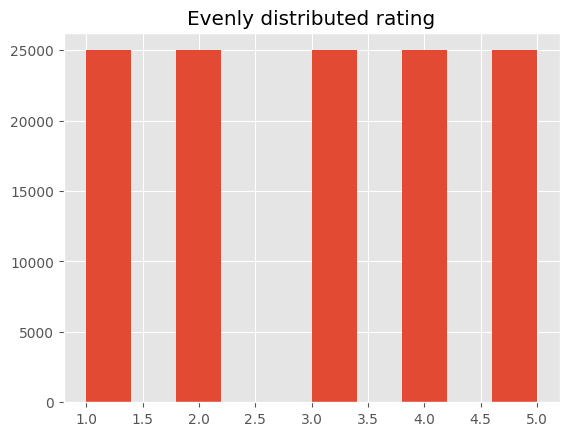

In [25]:
plt.hist(df_1.Score)
plt.title("Evenly distributed rating");

## Preprocessing

In [118]:
X = df_1.Text
y = df_1.Score

In [119]:
y = y - 1

In [120]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [121]:
y = to_categorical(y,num_classes=5, dtype=np.uint8)

In [122]:
y.shape

(125000, 5)

In [123]:
X = X.apply(preprocessing)

In [124]:
X.head()

Id
508383    search vegetarian foods appear one choices upo...
300948    purchase tea tell help excess gas tea make wor...
322338    first tie truvia fact decide replace truvia re...
567730    bad return children didnt even like difficult ...
340950    poor copy old victor trap legs short close tog...
Name: Text, dtype: object

In [ ]:
"508383    when i do a for this as of my at the i be be m"


(0.0, 1000.0)

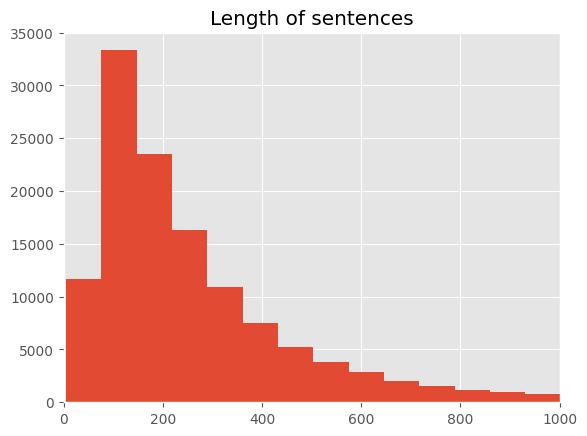

In [128]:
len_sentence = X.apply(lambda x : len(x))
plt.hist(len_sentence,bins=200)
plt.title("Length of sentences")
plt.xlim((0,1000))

In [129]:
tk = Tokenizer()
tk.fit_on_texts(X)
X_token = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_token,maxlen=300, dtype='float32', padding='post')
vocab_size = len(tk.word_index)

In [130]:
X_train,X_val,y_train,y_val = train_test_split(X_pad,y,test_size=0.2,random_state=0)

AttributeError: 'numpy.ndarray' object has no attribute 'title'

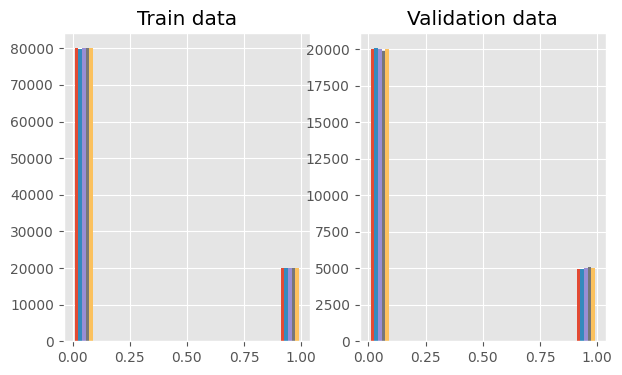

In [131]:
fig,axes = plt.subplots(1,2,figsize=(7,4))
axes[0].hist(y_train)
axes[0].set_title("Train data")
axes[1].hist(y_val)
axes[1].set_title("Validation data")
axes.title("Distribution of train and val")

## Model initialization

In [116]:
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size+1,output_dim=100, mask_zero=True))
model.add(layers.LSTM(20,activation="tanh",return_sequences=False))
model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(5,activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

es = EarlyStopping(patience=5,monitor="val_loss",restore_best_weights=True)

model.fit(X_train,y_train,epochs=50,batch_size=32,callbacks=es,validation_data=[X_val,y_val])

Epoch 1/50


2023-03-24 10:53:44.128987: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-03-24 10:53:45.780248: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 87s 26ms/step - loss: 1.4876 - accuracy: 0.3363 - val_loss: 1.4653 - val_accuracy: 0.3534
Epoch 2/50
3125/3125 [==============================] - 71s 23ms/step - loss: 1.4513 - accuracy: 0.3618 - val_loss: 1.4423 - val_accuracy: 0.3640
Epoch 3/50
3125/3125 [==============================] - 70s 23ms/step - loss: 1.4302 - accuracy: 0.3721 - val_loss: 1.4377 - val_accuracy: 0.3717
Epoch 4/50
3125/3125 [==============================] - 70s 22ms/step - loss: 1.4127 - accuracy: 0.3836 - val_loss: 1.4191 - val_accuracy: 0.3780
Epoch 5/50
2167/3125 [===================>..........] - ETA: 19s - loss: 1.3985 - accuracy: 0.3893

KeyboardInterrupt: 

In [111]:
X_train

Id
480201    we this and it have not a few more and they al...
207684    i have and and for this i that i to them a as ...
421689                     i the and of this i in i it as a
64223            they to this of the be them with this will
265848    my these he when i the to i up these to a them...
                                ...                        
494644    if a of the that be in then about this be in i...
467342       for the on our and we can it here in the be on
146841    my in with them or but when he do on them they...
350575    very but for it be not the if you have that be...
414716    be a if you a in the you should the i the of a...
Name: Text, Length: 100000, dtype: object